In [1]:
import shap
import xgboost 
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

In [29]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [3]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:8.88081
[1000]	test-cox-nloglik:8.16727
[2000]	test-cox-nloglik:8.07804
[3000]	test-cox-nloglik:8.03905
[4000]	test-cox-nloglik:8.01408
[5000]	test-cox-nloglik:7.99288
[6000]	test-cox-nloglik:7.97375
[7000]	test-cox-nloglik:7.95596
[8000]	test-cox-nloglik:7.93900
[9000]	test-cox-nloglik:7.92279
[9999]	test-cox-nloglik:7.90727


In [4]:
# accuracy measure for mortality score 
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [5]:
# see how well we can order people by survival
c_statistic_harrell(model.predict(xgb_test, ntree_limit=5000), y_test)

0.8524672561535008

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

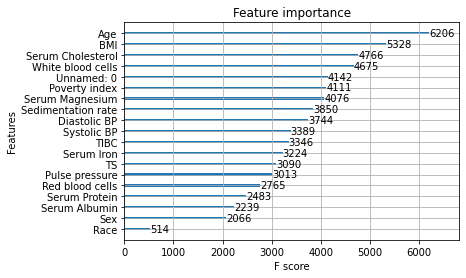

In [6]:
xgboost.plot_importance(model)

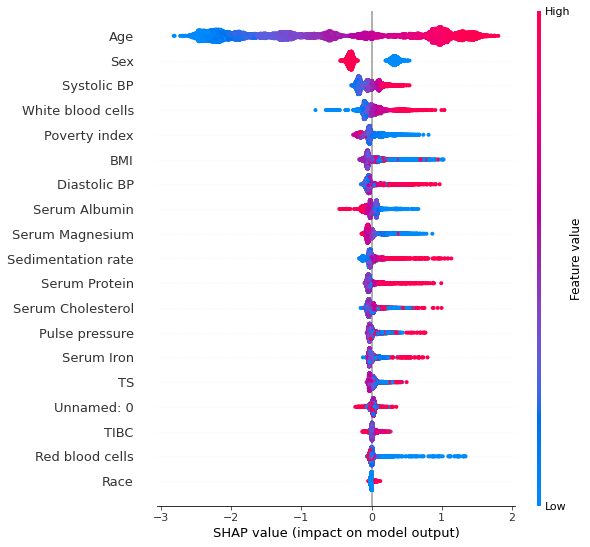

In [7]:
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

In [30]:
x_name = list(X.columns)
x_n = X_test.to_numpy()
print(x_n)

AttributeError: 'DataFrame' object has no attribute 'to_numpy'

In [31]:
import lime
import lime.lime_tabular
def wrapped(data_x):
    
    dummy_y = np.array([ 1 for _ in range(data_x.shape[0]) ])
    tmp_data = xgb.DMatrix(data_x, dummy_y, feature_names=x_name)
    
    tmp_out = model.predict(tmp_data)
    
    # add the first column to make it like predict_proba
    out = np.zeros((data_x.shape[0], 2))
    out[:, 0] = 1-tmp_out
    out[:, 1] = tmp_out
    
    return out
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=x_name, 
                                                   verbose=True, 
                                                   discretize_continuous=False,
                                                   mode='regression')
expXGB = explainer.explain_instance(X_test.values[8], wrapped, num_features=19)
expXGB.show_in_notebook(show_table=True)

Intercept -0.0438949686106464
Prediction_local [-0.45016563]
Right: 0.8685343265533447


In [41]:
params = {
    "eta": 0.01,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:7.25687
[1000]	test-cox-nloglik:6.47788
[2000]	test-cox-nloglik:6.48924
[3000]	test-cox-nloglik:6.50664
[4000]	test-cox-nloglik:6.52727
[5000]	test-cox-nloglik:6.54838
[6000]	test-cox-nloglik:6.57486
[7000]	test-cox-nloglik:6.58910
[8000]	test-cox-nloglik:6.60541
[9000]	test-cox-nloglik:6.62127
[9999]	test-cox-nloglik:6.63974


In [42]:
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8311100700747595

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

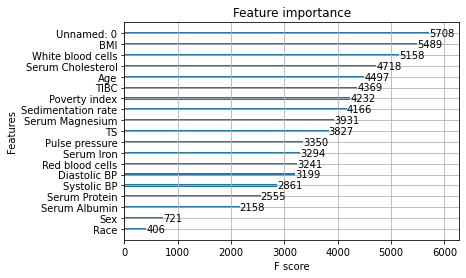

In [44]:
xgboost.plot_importance(model_train)

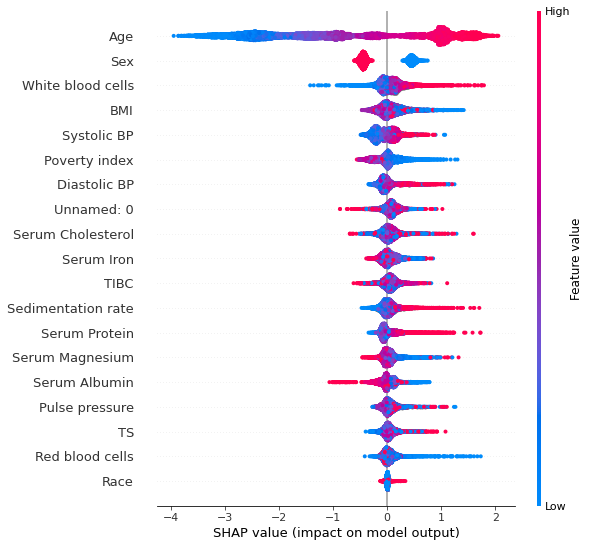

In [43]:
shap_values = shap.TreeExplainer(model_train).shap_values(X)
shap.summary_plot(shap_values, X)

In [32]:
"""X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)"""
# get a subsample from above code to train
xgb_train_sub = xgboost.DMatrix(X_train[:30], label=y_train[:30])
xgb_test_sub = xgboost.DMatrix(X_test[:30], label=y_test[:30])

params = {
    "eta": 0.1,
    "max_depth": 1, 
    "objective": "survival:cox",
    "subsample": 1
}
model_sub = xgboost.train(params, xgb_train_sub, 5000, evals = [(xgb_test_sub, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:2.93243
[1000]	test-cox-nloglik:5.30334
[2000]	test-cox-nloglik:6.14106
[3000]	test-cox-nloglik:7.18440
[4000]	test-cox-nloglik:9.05118
[4999]	test-cox-nloglik:10.45964


In [33]:
c_statistic_harrell(model_sub.predict(xgb_test, ntree_limit=5000), y_test)

0.6896224941929691

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

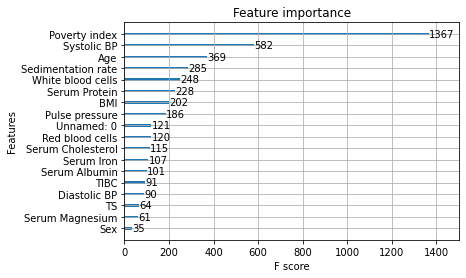

In [76]:
xgboost.plot_importance(model_sub)

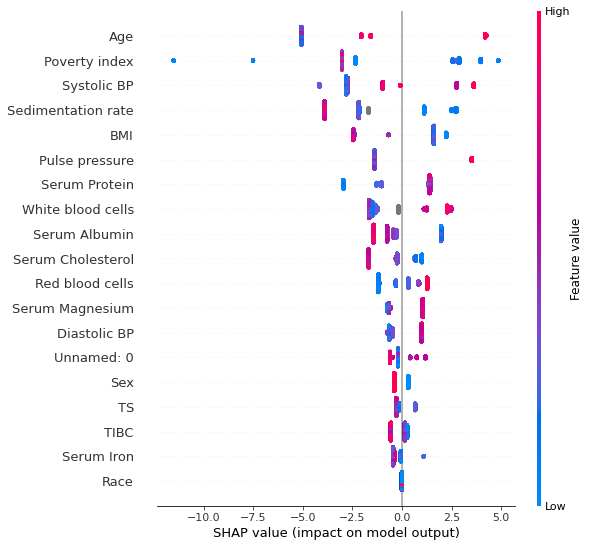

In [34]:
sub_shap_values = shap.TreeExplainer(model_sub).shap_values(X)
shap.summary_plot(sub_shap_values, X)

In [ ]:
def wrapped_epic(data_x):
    
    dummy_y = np.array([ 1 for _ in range(data_x.shape[0]) ])
    tmp_data = xgb.DMatrix(data_x, dummy_y, feature_names=x_name)
    
    tmp_out = model_sub.predict(tmp_data)
    
    # add the first column to make it like predict_proba
    out = np.zeros((data_x.shape[0], 2))
    out[:, 0] = 1-tmp_out
    out[:, 1] = tmp_out
    
    return out
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=x_name, 
                                                   verbose=True, 
                                                   discretize_continuous=False,
                                                   mode='regression')
expXGB = explainer.explain_instance(X_test.values[8], wrapped, num_features=19)
expXGB.show_in_notebook(show_table=True)

In [21]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.externals import joblib
from sklearn.metrics import precision_score
import pandas as pd

In [22]:
df=pd.read_csv('housing.csv')
df = df.drop('ocean_proximity',axis=1)
print(df.describe())
x=df.drop('median_house_value',axis=1).values
y=df['median_house_value'].values
col_label = df.drop('median_house_value',axis=1).columns.values.tolist()
print(col_label)
print(len(col_label))

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=0)
print(xtrain.shape)

# scale the features
ms=MinMaxScaler()
xtrain=ms.fit_transform(xtrain)
xtest=ms.transform(xtest)
print(xtrain.shape)


x_train = xgboost.DMatrix(xtrain, label=ytrain,feature_names=col_label)
x_test = xgboost.DMatrix(xtest, label=ytest,feature_names=col_label)

params = {
    "eta": 0.025,
    "max_depth": 4, 
    "subsample": 0.5
}

model_h = xgboost.train(params, x_train, 10000, evals = [(x_test, "test")], verbose_eval=1000)

(14448, 8)
(14448, 8)
[0]	test-rmse:231656.65625
[1000]	test-rmse:48937.78125
[2000]	test-rmse:47310.96484
[3000]	test-rmse:46593.79688
[4000]	test-rmse:46231.48047
[5000]	test-rmse:46012.10547
[6000]	test-rmse:45948.82031
[7000]	test-rmse:45973.62500
[8000]	test-rmse:45957.70703
[9000]	test-rmse:45959.36328
[9999]	test-rmse:46014.17578


In [47]:
from sklearn.metrics import explained_variance_score
predictions = model_h.predict(x_test)
print(ytest)
print(predictions)
accuracy = explained_variance_score(ytest, predictions)
print('Accuracy is', accuracy)

[136900. 241300. 200700. ... 351900.  92500. 298300.]
[147041.   236476.   140143.   ... 389134.84  84903.87 253392.12]
Accuracy is 0.8412739421238367


In [24]:
print(type(xtest))

<class 'numpy.ndarray'>


In [37]:
import lime
import lime.lime_tabular
def wrapped_predict(data_x):
    
    dummy_y = np.array([ 1 for _ in range(data_x.shape[0]) ])
    tmp_data = xgb.DMatrix(data_x, dummy_y, feature_names=col_label)
    
    tmp_out = model_h.predict(tmp_data)
    
    # add the first column to make it like predict_proba
    out = np.zeros((data_x.shape[0], 2))
    out[:, 0] = 1-tmp_out
    out[:, 1] = tmp_out
    
    return out

explainer = lime.lime_tabular.LimeTabularExplainer(xtrain, 
                                                   feature_names=col_label, 
                                                   verbose=True, 
                                                   discretize_continuous=False,
                                                   mode='regression')
expXGB = explainer.explain_instance(xtest[0], wrapped_predict, num_features=8)
expXGB.show_in_notebook(show_table=True)

Intercept -329528.6983325358
Prediction_local [-438527.81878976]
Right: -147040.0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

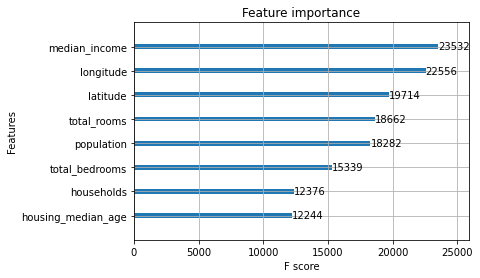

In [24]:
xgboost.plot_importance(model_h)

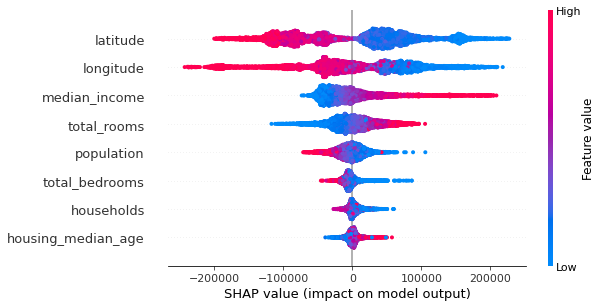

In [25]:
h_shap_values = shap.TreeExplainer(model_h).shap_values(xtest)
shap.summary_plot(h_shap_values, xtest,feature_names=col_label)

In [38]:
x_train_sub = xgboost.DMatrix(xtrain[:100], label=ytrain[:100],feature_names=col_label)
x_test_sub = xgboost.DMatrix(xtest[:100], label=ytest[:100],feature_names=col_label)

params = {
    "eta": 0.06,
    "max_depth": 1, 
    "subsample": 0.6
}

model_h_sub = xgboost.train(params, x_train_sub, 5000, evals = [(x_test_sub, "test")], verbose_eval=1000)

[0]	test-rmse:220882.28125
[1000]	test-rmse:78730.64062
[2000]	test-rmse:78868.60156
[3000]	test-rmse:78958.13281
[4000]	test-rmse:78993.07812
[4999]	test-rmse:78961.39844


In [38]:
from sklearn.metrics import explained_variance_score
predictions = model_h_sub.predict(x_test)
print(ytest)
print(predictions)
accuracy = explained_variance_score(ytest, predictions)
print('Accuracy is', accuracy)

[136900. 241300. 200700. ... 351900.  92500. 298300.]
[135365.3  307784.12 185077.88 ... 414272.2  117942.63 293764.5 ]
Accuracy is 0.5364274357019562


In [56]:
def wrapped_predict_sub(data_x):
    
    dummy_y = np.array([ 1 for _ in range(data_x.shape[0]) ])
    tmp_data = xgb.DMatrix(data_x, dummy_y, feature_names=col_label)
    
    tmp_out = model_h_sub.predict(tmp_data)
    print(tmp_out)
    # add the first column to make it like predict_proba
    out = np.zeros((data_x.shape[0], 2))
    out[:, 0] = 1-tmp_out
    out[:, 1] = tmp_out
    print(out)
    return out

explainer = lime.lime_tabular.LimeTabularExplainer(xtrain, 
                                                   feature_names=col_label, 
                                                   verbose=True, 
                                                   discretize_continuous=False,
                                                   mode='regression')
expXGB = explainer.explain_instance(xtest[0], wrapped_predict_sub, num_features=8)
expXGB.show_in_notebook(show_table=True)

[135365.3  260764.67 424013.72 ... 539483.2  212558.16 188595.72]
[[-135364.296875  135365.296875]
 [-260763.671875  260764.671875]
 [-424012.71875   424013.71875 ]
 ...
 [-539482.1875    539483.1875  ]
 [-212557.15625   212558.15625 ]
 [-188594.71875   188595.71875 ]]
Intercept -185442.56782638785
Prediction_local [-208234.33409656]
Right: -135364.296875


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

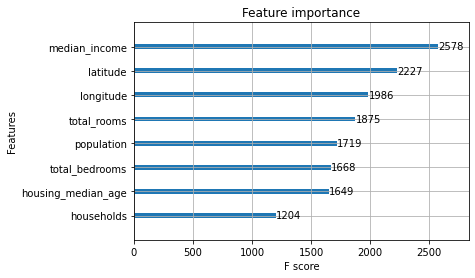

In [109]:
xgboost.plot_importance(model_h_sub)

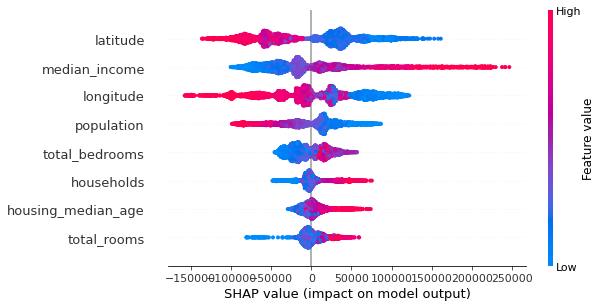

In [111]:
sub_h_shap_values = shap.TreeExplainer(model_h_sub).shap_values(xtest)
shap.summary_plot(sub_h_shap_values, xtest,feature_names=col_label)

In [25]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.externals import joblib
from sklearn.metrics import precision_score

iris = datasets.load_iris()
X = iris.data
y = iris.target
c_names = iris['target_names']
f_names = iris['feature_names']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# use DMatrix for xgbosot
dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=f_names)
dtest = xgb.DMatrix(X_test, label=y_test,feature_names=f_names)

"""
# use svmlight file for xgboost
dump_svmlight_file(X_train, y_train, 'dtrain.svm', zero_based=True)
dump_svmlight_file(X_test, y_test, 'dtest.svm', zero_based=True)
dtrain_svm = xgb.DMatrix('dtrain.svm')
dtest_svm = xgb.DMatrix('dtest.svm')
"""


# set xgboost params
param = {
    'max_depth': 1,  # the maximum depth of each tree
    'eta': 0.9,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

# training and testing - numpy matrices
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array precision:", precision_score(y_test, best_preds, average='macro'))


Numpy array precision: 1.0


In [27]:
print(type(X))

<class 'numpy.ndarray'>


In [60]:
def wrapped_predict_bst(data_x):
    
    dummy_y = np.array([ 1 for _ in range(data_x.shape[0]) ])
    tmp_data = xgb.DMatrix(data_x, dummy_y, feature_names=f_names)
    
    tmp_out = bst.predict(tmp_data)
    
    return tmp_out

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                   feature_names=f_names, 
                                                   class_names=c_names,
                                                   verbose=True, 
                                                   discretize_continuous=False,
                                                   mode='classification')
expXGB = explainer.explain_instance(X_test[0], wrapped_predict_bst, num_features=4)
expXGB.show_in_notebook(show_table=True)

Intercept 0.6278681059558863
Prediction_local [0.57492471]
Right: 0.9649363


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

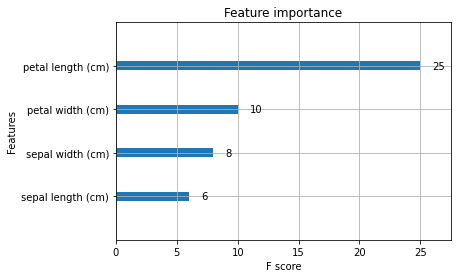

In [14]:
xgb.plot_importance(bst)

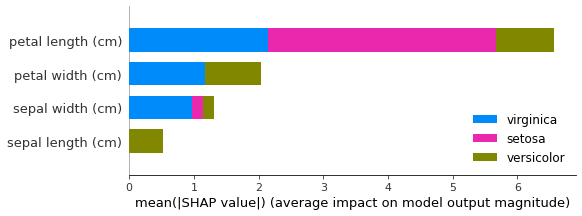

In [18]:
bst_shap_values = shap.TreeExplainer(bst).shap_values(X_test)
shap.summary_plot(bst_shap_values, X_test,feature_names=f_names,class_names=c_names)